In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm.autonotebook import tqdm
from joblib import Parallel, delayed
import umap
import pandas as pd

/home/AD/tsainbur/miniconda3/envs/tim_py3/lib/python3.7/site-packages/tqdm/autonotebook.py:17: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [3]:
from avgn.utils.paths import DATA_DIR, most_recent_subdirectory, ensure_dir
from avgn.signalprocessing.create_spectrogram_dataset import flatten_spectrograms
from avgn.visualization.spectrogram import draw_spec_set
from avgn.visualization.quickplots import draw_projection_plots

### Collect data

In [4]:
DATASET_ID = 'canary_segmented'

In [5]:
from avgn.utils.hparams import HParams
from avgn.dataset import DataSet

In [6]:
hparams = HParams()
# create a dataset object
dataset = DataSet(DATASET_ID, hparams = hparams)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    1.4s


[Parallel(n_jobs=-1)]: Done 2320 out of 2320 | elapsed:    1.8s finished


In [7]:
from avgn.visualization.projections import (
    scatter_projections,
    draw_projection_transitions,
)

In [8]:
df_loc =  DATA_DIR / 'syllable_dfs' / DATASET_ID / 'canary.pickle'
df_loc

PosixPath('/home/AD/tsainbur/github_repos/avgn_paper/data/syllable_dfs/canary_segmented/canary.pickle')

In [9]:
syllable_df = pd.read_pickle(df_loc)

### add label data to df

In [10]:
syllable_df['phrase'] = None
syllable_df['med_time'] = (syllable_df.start_time + syllable_df.end_time)/2

In [11]:
syllable_dfs = []
for key in tqdm(syllable_df.key.unique()):
    key_data = dataset.data_files[key].data["indvs"][
        list(dataset.data_files[key].data["indvs"].keys())[0]
    ]["phrases"]
    syllable_df_key = syllable_df[syllable_df.key == key]
    key_spots = syllable_df.key == key
    for st, ed, lab in zip(
        key_data["start_times"], key_data["end_times"], key_data["labels"]
    ):
        syllable_df_key.loc[
            (syllable_df_key.med_time >= st)
            & (syllable_df_key.med_time <= ed),
            "phrase",
        ] = lab
    syllable_dfs.append(syllable_df_key)
syllable_df = pd.concat(syllable_dfs)
syllable_df = syllable_df[syllable_df.phrase.values!=None]

/home/AD/tsainbur/miniconda3/envs/tim_py3/lib/python3.7/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [12]:
syllable_df[:3]

start_time  end_time   indv  indvi                          key  \
0       0.000     0.036  bird3      0  bird3_0525_2004_04_19_16_06   
1       0.101     0.136  bird3      0  bird3_0525_2004_04_19_16_06   
2       0.208     0.247  bird3      0  bird3_0525_2004_04_19_16_06   

                                               audio   rate  \
0  [-0.013927590325060985, -0.09374820877158284, ...  48000   
1  [-0.08033924279200529, -0.1427361110642931, -0...  48000   
2  [0.20502230290406648, 0.16692246300221994, 0.1...  48000   

                                         spectrogram phrase  med_time  
0  [[0, 0, 0, 0, 0, 0, 206, 254, 90, 0, 18, 0, 0,...      2    0.0180  
1  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...      2    0.1185  
2  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...      2    0.2275

In [13]:
len(syllable_df)

494946

bird3 131501


8


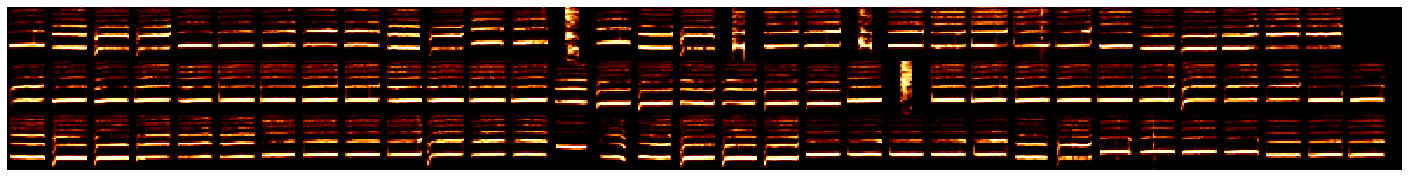

4


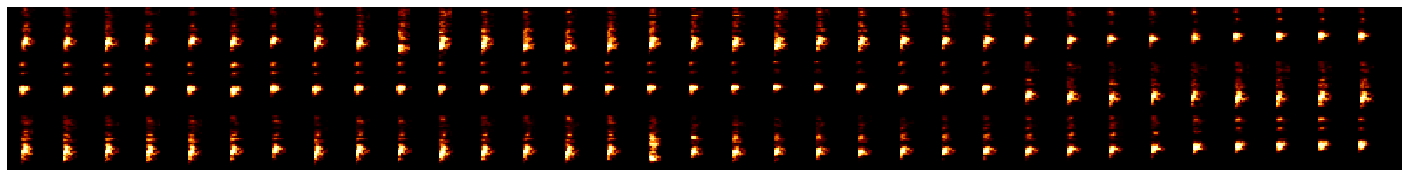

17


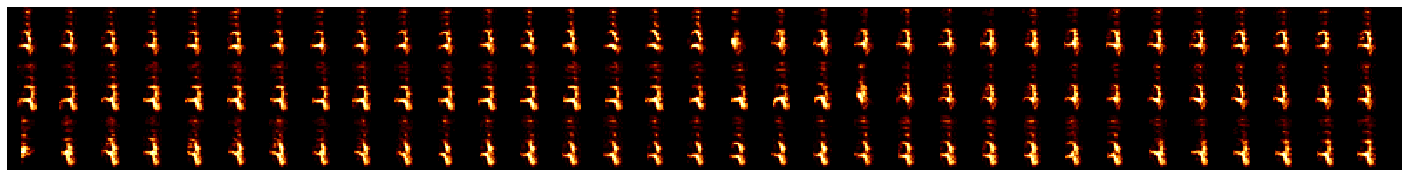

13


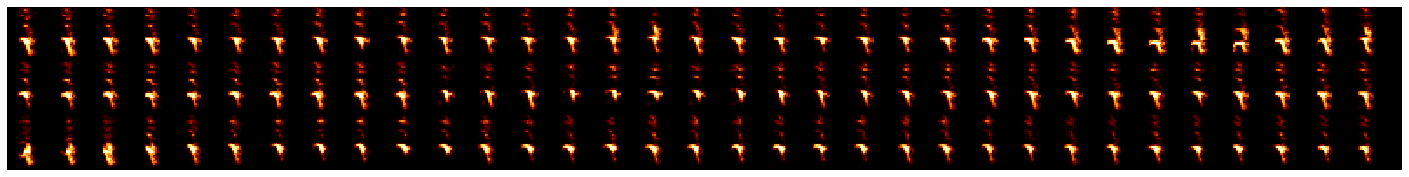

22


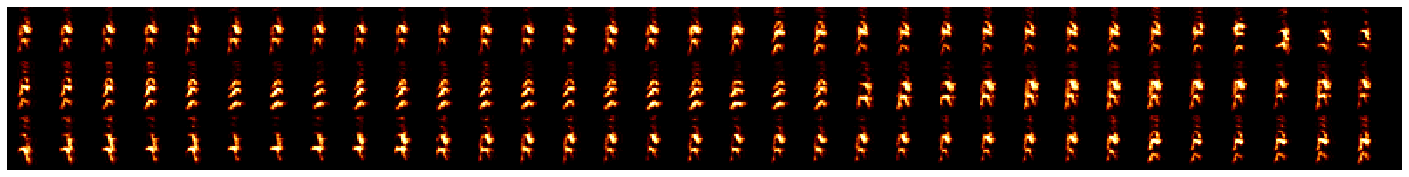

6


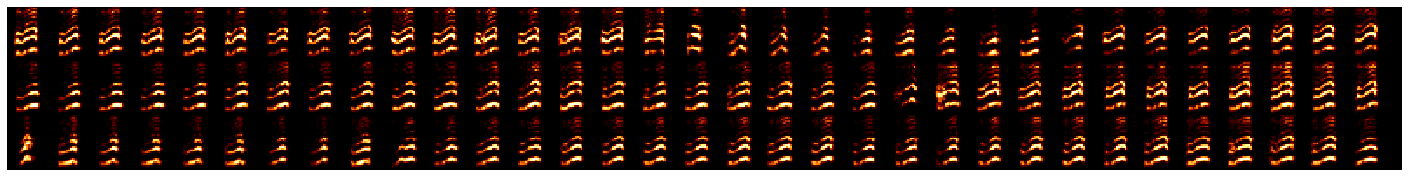

3


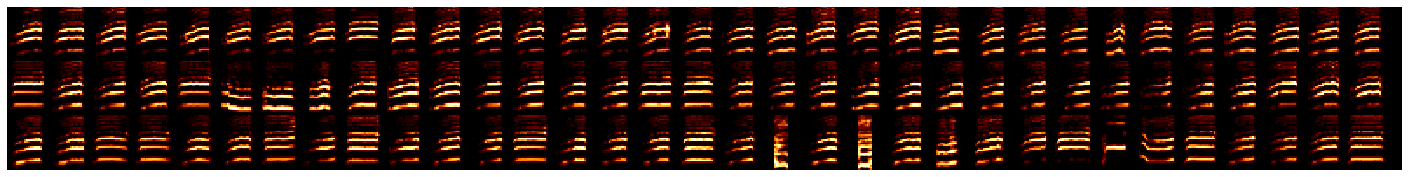

7


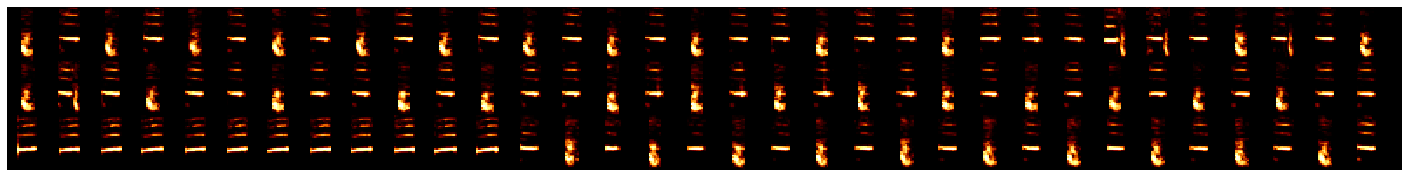

18


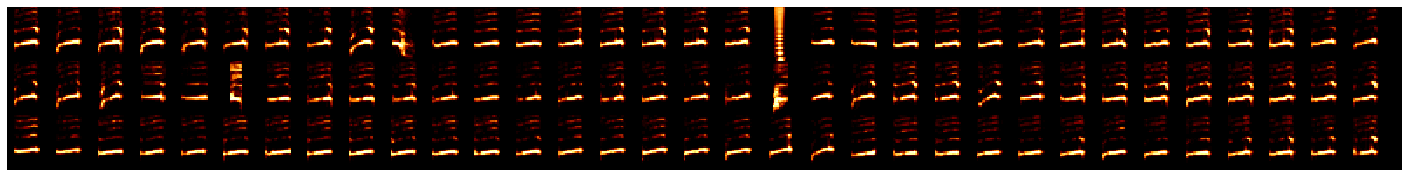

19


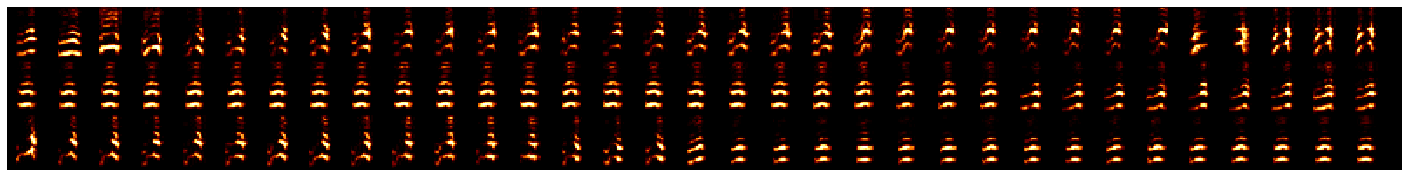

5


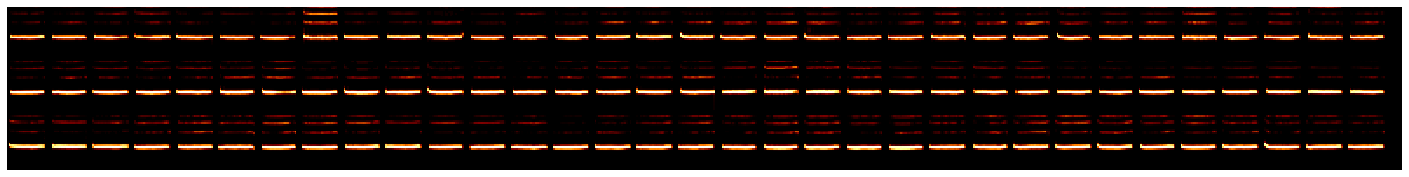

14


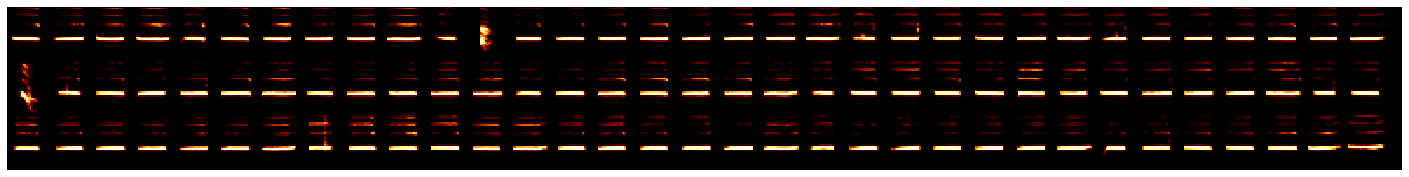

21


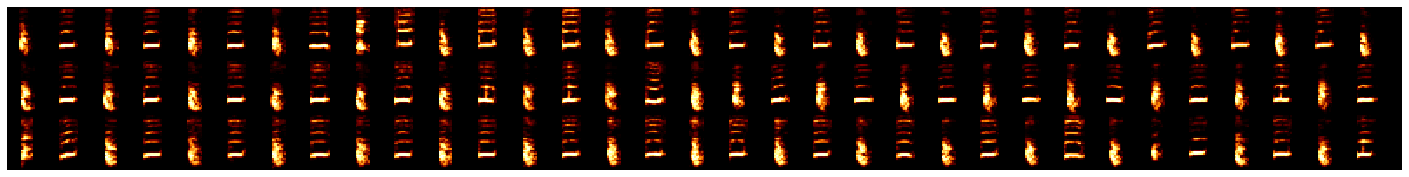

20


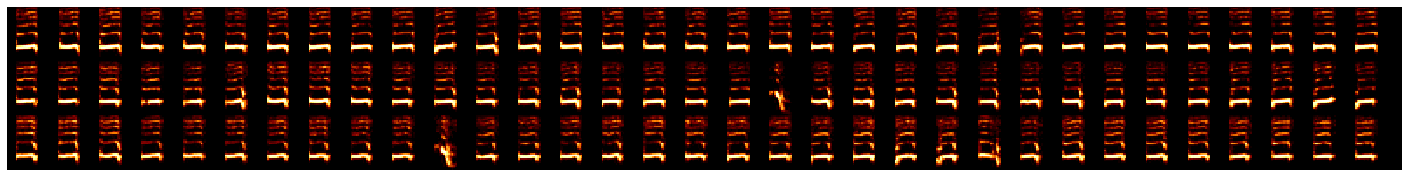

16


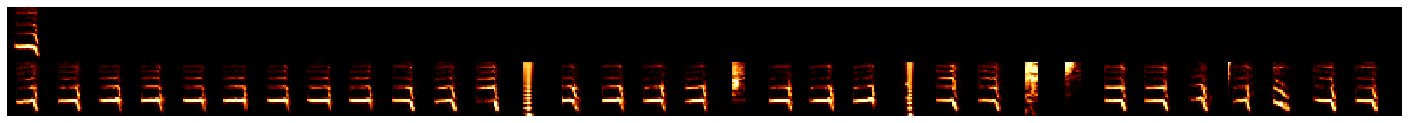

11


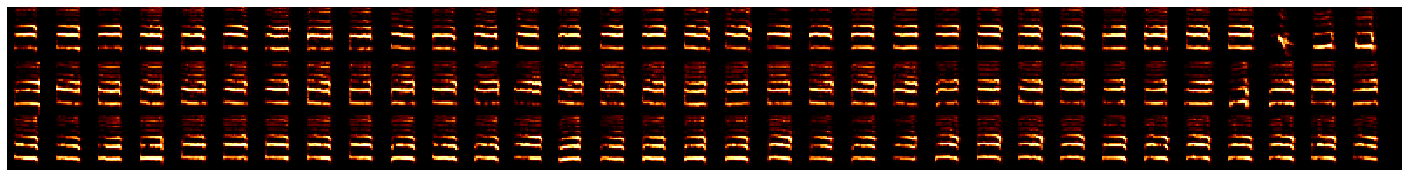

2


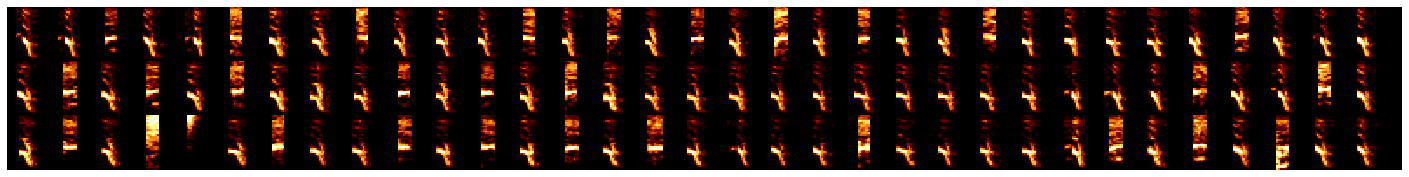

9


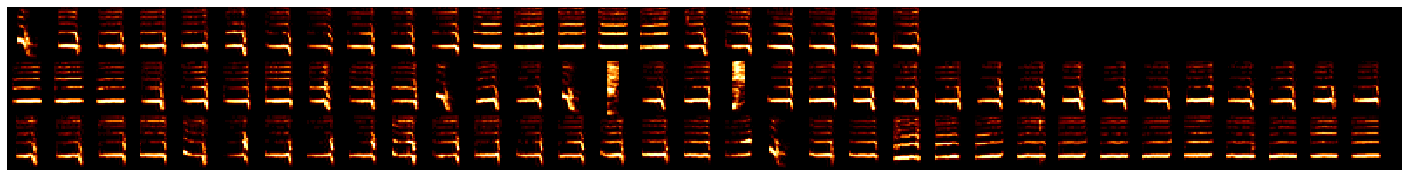

1


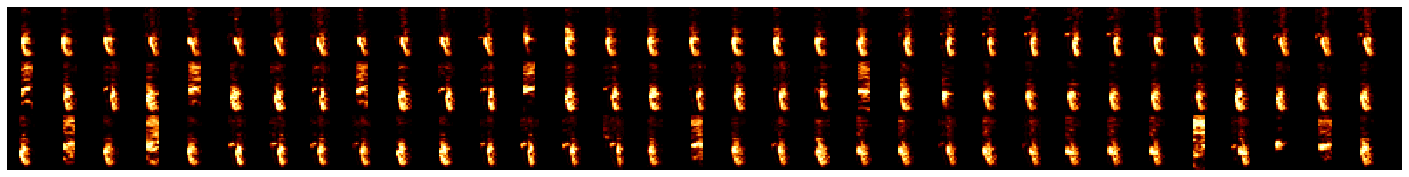

15


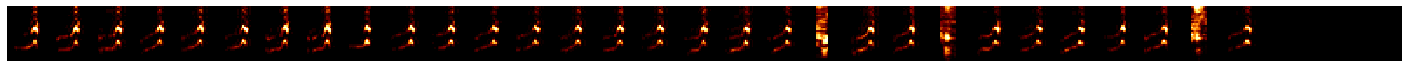

10


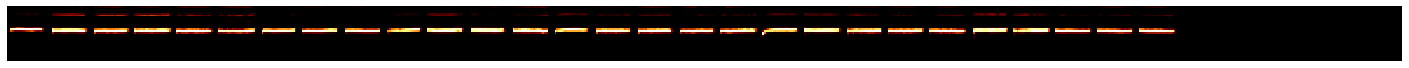

12


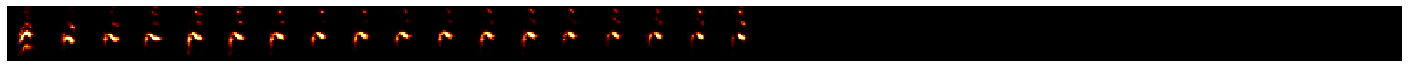

In [14]:
for indv in tqdm(syllable_df.indv.unique()):
    indv_df = syllable_df[syllable_df.indv == indv]
    indv_df = indv_df.sort_values(by=["key", "start_time"])
    print(indv, len(indv_df))
    indv_df = indv_df[:20000]
    for phrase in tqdm(indv_df.phrase.unique(), leave=False):
        print(phrase)
        specs = list(indv_df[indv_df.phrase == phrase].spectrogram.values)
        draw_spec_set(specs, zoom=1, maxrows=3, colsize=25)
    break

In [15]:
def norm(x):
    return (x - np.min(x)) / (np.max(x) - np.min(x))

### cluster

In [16]:
from avgn.visualization.projections import scatter_spec
from avgn.utils.general import save_fig
from avgn.utils.paths import FIGURE_DIR, ensure_dir

bird3 131501


/home/AD/tsainbur/miniconda3/envs/tim_py3/lib/python3.7/site-packages/numba/compiler.py:602: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../miniconda3/envs/tim_py3/lib/python3.7/site-packages/umap/rp_tree.py", line 135:
@numba.njit(fastmath=True, nogil=True, parallel=True)
def euclidean_random_projection_split(data, indices, rng_state):
^

  self.func_ir.loc))


/home/AD/tsainbur/miniconda3/envs/tim_py3/lib/python3.7/site-packages/umap/nndescent.py:92: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../miniconda3/envs/tim_py3/lib/python3.7/site-packages/umap/utils.py", line 409:
@numba.njit(parallel=True)
def build_candidates(current_graph, n_vertices, n_neighbors, max_candidates, rng_state):
^

  current_graph, n_vertices, n_neighbors, max_candidates, rng_state
/home/AD/tsainbur/miniconda3/envs/tim_py3/lib/python3.7/site-packages/numba/compiler.py:602: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html

/home/AD/tsainbur/github_repos/avgn_paper/avgn/visualization/network_graph.py:58: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos_locs = np.vstack(pos.values())
/home/AD/tsainbur/github_repos/avgn_paper/avgn/visualization/network_graph.py:265: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/home/AD/tsainbur/github_repos/avgn_paper/avgn/visualization/network_graph.py:272: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  and cb.iterable(edge_color)
/home/AD/tsainbur/github_repos/avgn_paper/avgn/visualization/network_graph.py:281: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib

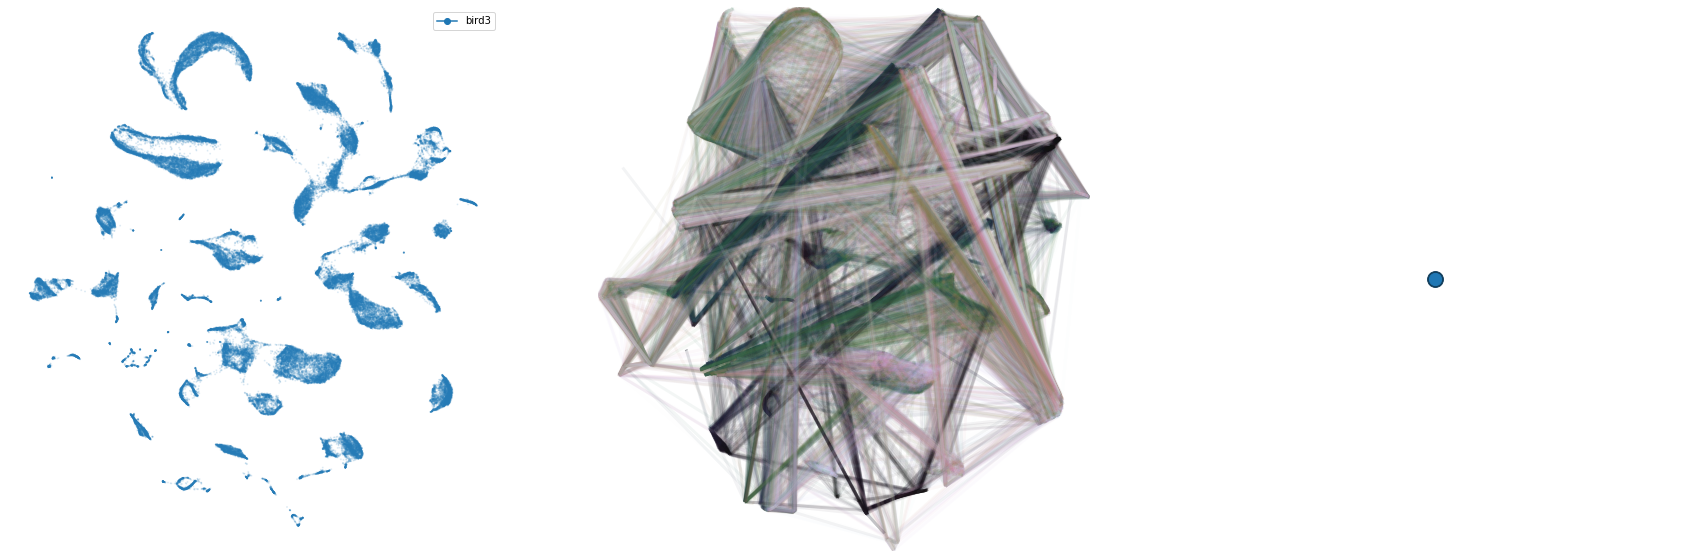

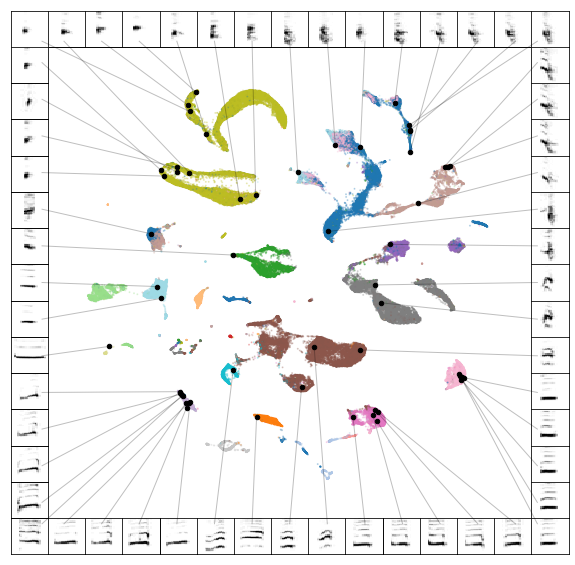

bird4 113897


/home/AD/tsainbur/miniconda3/envs/tim_py3/lib/python3.7/site-packages/numba/compiler.py:602: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../miniconda3/envs/tim_py3/lib/python3.7/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  self.func_ir.loc))
/home/AD/tsainbur/miniconda3/envs/tim_py3/lib/python3.7/site-packages/umap/spectral.py:229: UserWarning: Embedding a total of 2 separate connected components using meta-embedding (experimental)
  n_components


/home/AD/tsainbur/github_repos/avgn_paper/avgn/visualization/network_graph.py:58: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos_locs = np.vstack(pos.values())
/home/AD/tsainbur/github_repos/avgn_paper/avgn/visualization/network_graph.py:265: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/home/AD/tsainbur/github_repos/avgn_paper/avgn/visualization/network_graph.py:272: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  and cb.iterable(edge_color)
/home/AD/tsainbur/github_repos/avgn_paper/avgn/visualization/network_graph.py:281: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib

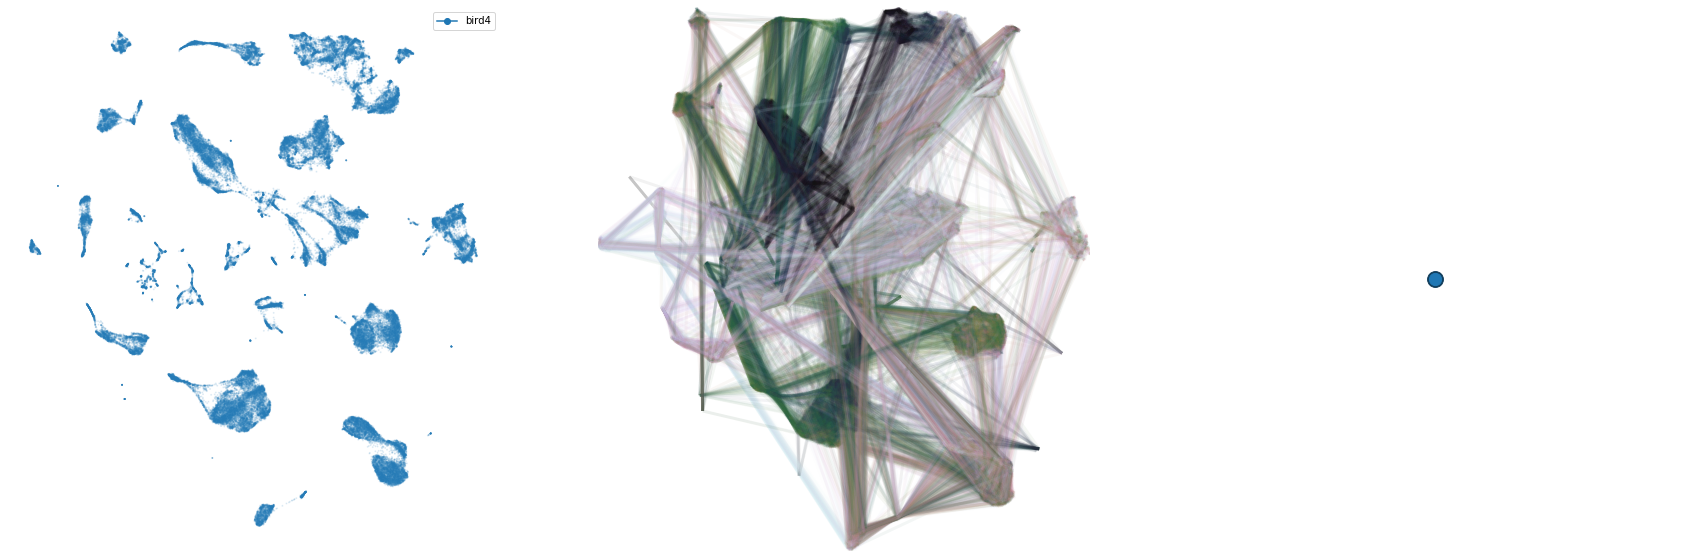

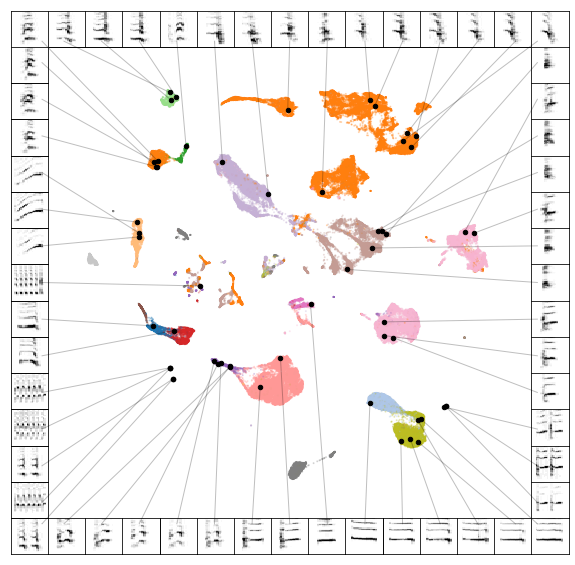

bird1 106883


/home/AD/tsainbur/miniconda3/envs/tim_py3/lib/python3.7/site-packages/numba/compiler.py:602: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../miniconda3/envs/tim_py3/lib/python3.7/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  self.func_ir.loc))


/home/AD/tsainbur/github_repos/avgn_paper/avgn/visualization/network_graph.py:58: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos_locs = np.vstack(pos.values())
/home/AD/tsainbur/github_repos/avgn_paper/avgn/visualization/network_graph.py:265: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/home/AD/tsainbur/github_repos/avgn_paper/avgn/visualization/network_graph.py:272: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  and cb.iterable(edge_color)
/home/AD/tsainbur/github_repos/avgn_paper/avgn/visualization/network_graph.py:281: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib

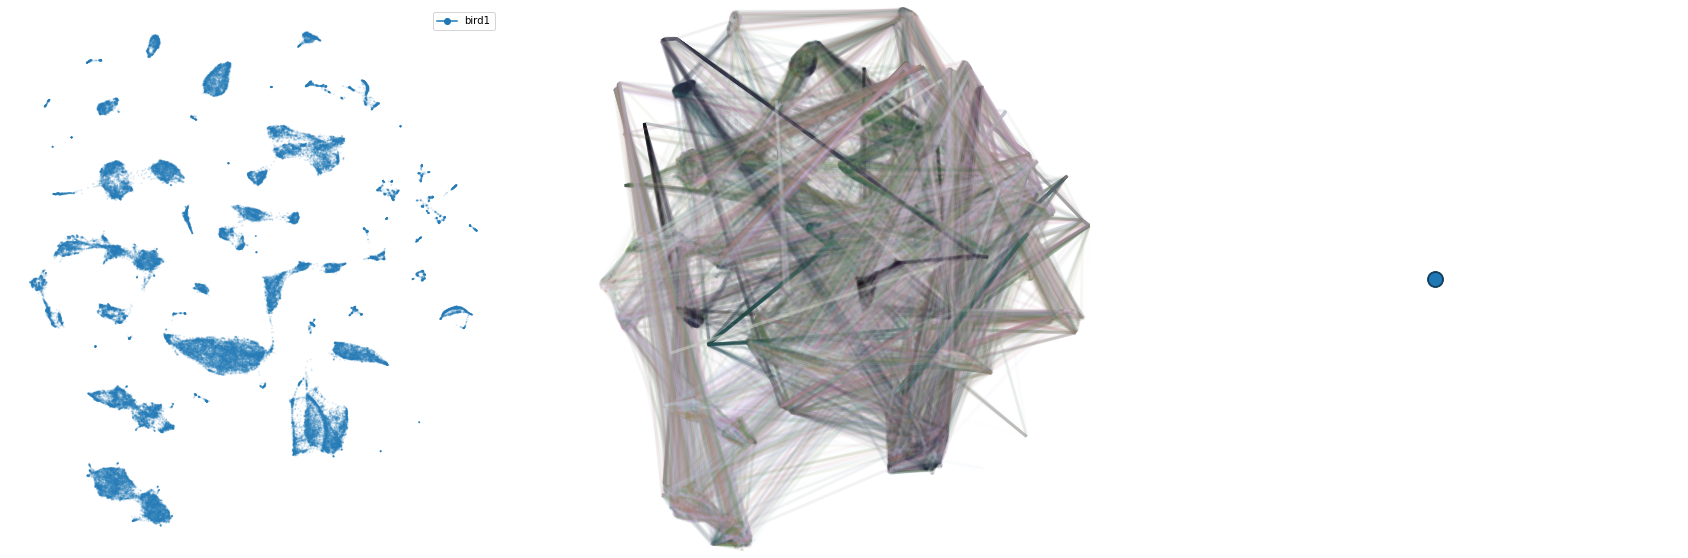

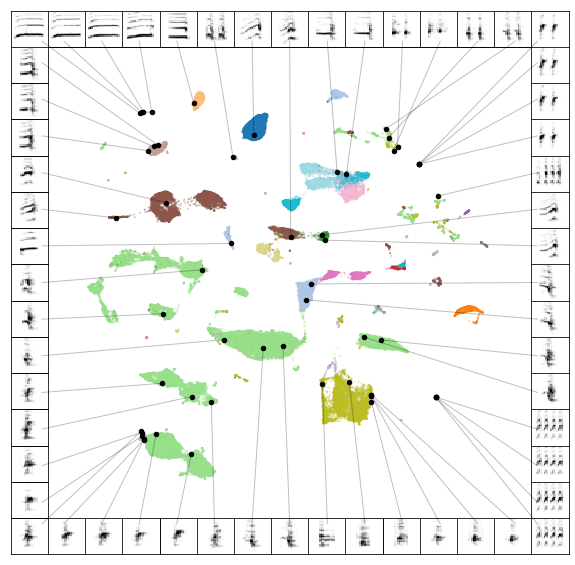

bird6 105790


/home/AD/tsainbur/miniconda3/envs/tim_py3/lib/python3.7/site-packages/numba/compiler.py:602: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../miniconda3/envs/tim_py3/lib/python3.7/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  self.func_ir.loc))


/home/AD/tsainbur/github_repos/avgn_paper/avgn/visualization/network_graph.py:58: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos_locs = np.vstack(pos.values())
/home/AD/tsainbur/github_repos/avgn_paper/avgn/visualization/network_graph.py:265: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/home/AD/tsainbur/github_repos/avgn_paper/avgn/visualization/network_graph.py:272: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  and cb.iterable(edge_color)
/home/AD/tsainbur/github_repos/avgn_paper/avgn/visualization/network_graph.py:281: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib

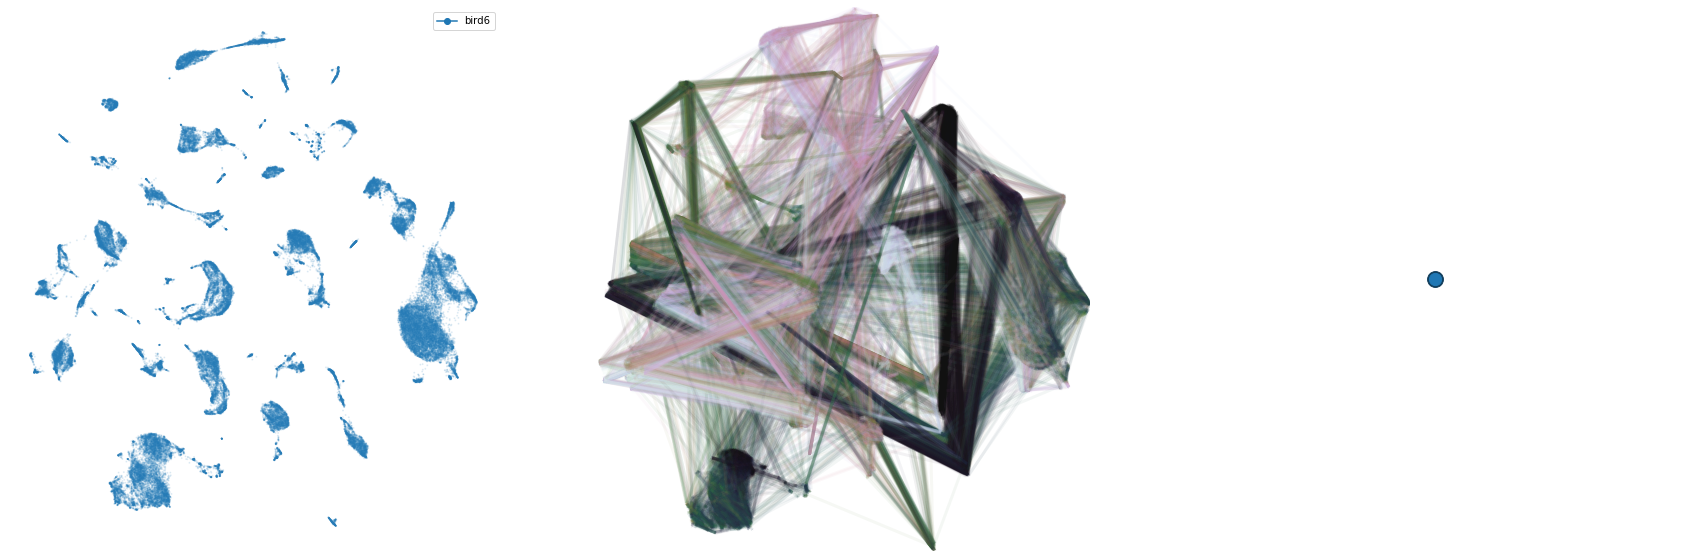

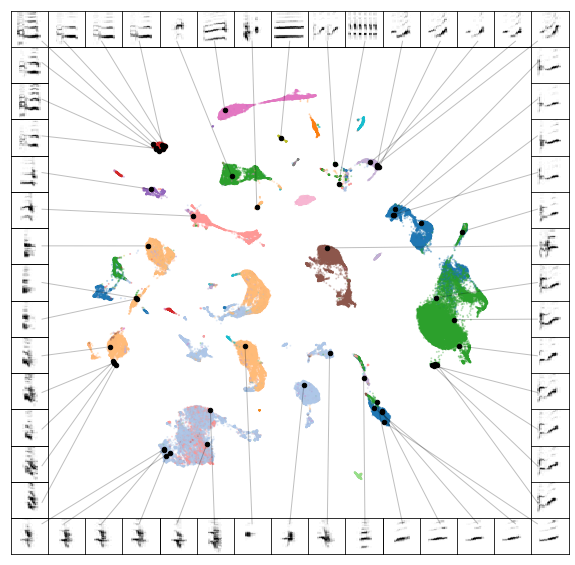

bird2 36875


/home/AD/tsainbur/miniconda3/envs/tim_py3/lib/python3.7/site-packages/numba/compiler.py:602: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../miniconda3/envs/tim_py3/lib/python3.7/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  self.func_ir.loc))


/home/AD/tsainbur/github_repos/avgn_paper/avgn/visualization/network_graph.py:58: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos_locs = np.vstack(pos.values())
/home/AD/tsainbur/github_repos/avgn_paper/avgn/visualization/network_graph.py:265: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/home/AD/tsainbur/github_repos/avgn_paper/avgn/visualization/network_graph.py:272: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  and cb.iterable(edge_color)
/home/AD/tsainbur/github_repos/avgn_paper/avgn/visualization/network_graph.py:281: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib

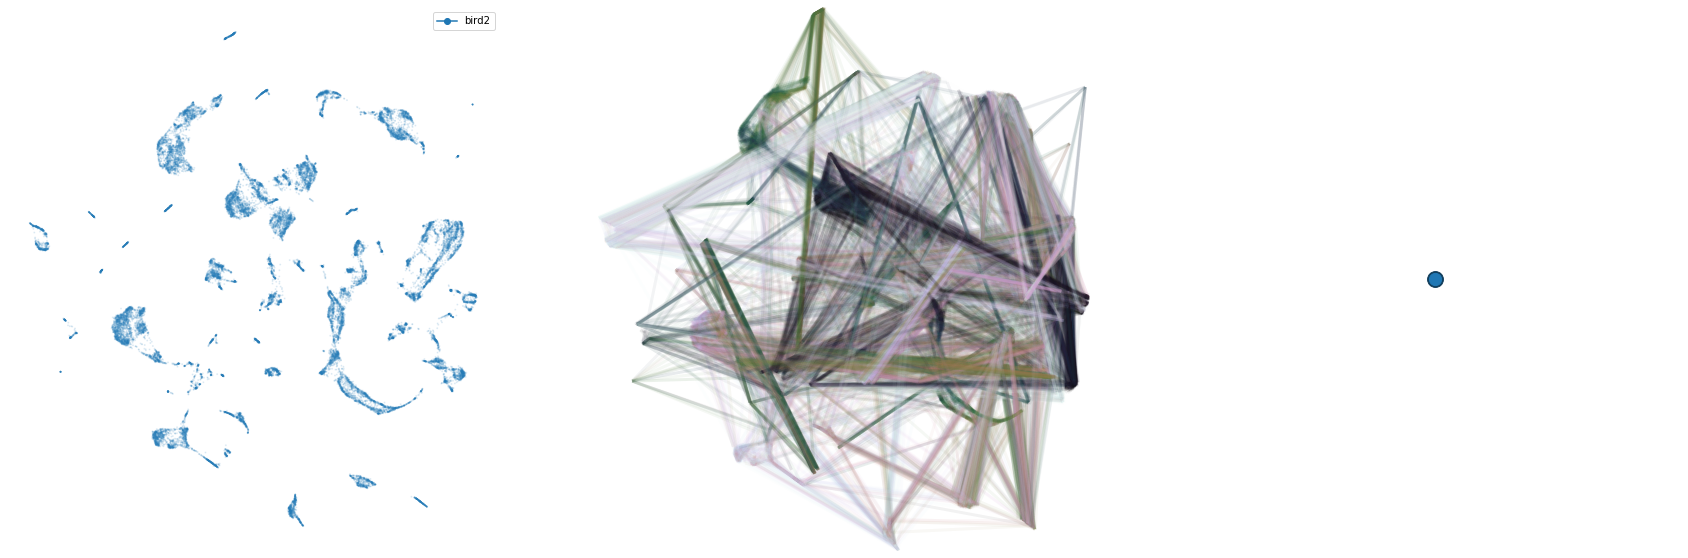

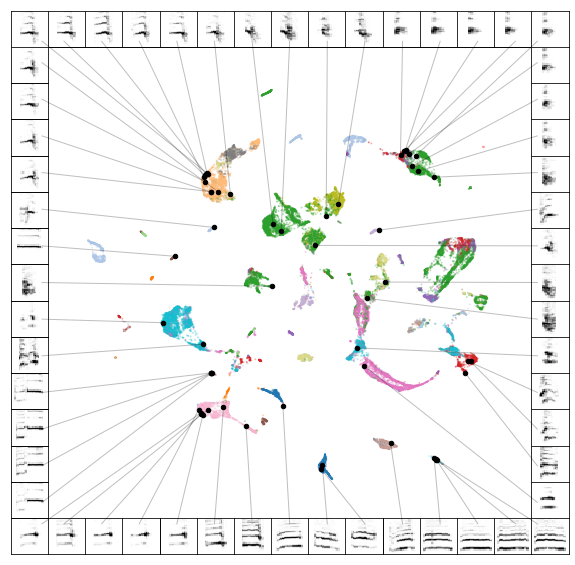

In [17]:
for indv in tqdm(syllable_df.indv.unique()):
    indv_df = syllable_df[syllable_df.indv == indv]
    indv_df = indv_df.sort_values(by=["key", "start_time"])
    print(indv, len(indv_df))
    #indv_df = indv_df[:20000]
    specs = list(indv_df.spectrogram.values)
    #draw_spec_set(specs, zoom=1, maxrows=10, colsize=25)
    # umap
    specs_flattened = flatten_spectrograms(specs)
    fit = umap.UMAP()
    z = list(fit.fit_transform(specs_flattened))
    indv_df["umap"] = z
    
    # sequencing
    indv_df["syllables_sequence_id"] = None
    indv_df["syllables_sequence_pos"] = None
    for ki, key in enumerate(indv_df.key.unique()):
        indv_df.loc[indv_df.key == key, "syllables_sequence_id"] = ki
        indv_df.loc[indv_df.key == key, "syllables_sequence_pos"] = np.arange(
            np.sum(indv_df.key == key)
        )
        
    # plot
    draw_projection_plots(indv_df, label_column="indv")
    plt.show()
    
    scatter_spec(
        np.vstack(z),
        specs,
        column_size=15,
        #x_range = [-5.5,7],
        #y_range = [-10,10],
        pal_color="hls",
        color_points=False,
        enlarge_points=20,
        figsize=(10, 10),
        scatter_kwargs = {
            'labels': list(indv_df.phrase.values),
            'alpha':0.25,
            's': 1,
            'show_legend': False
        },
        matshow_kwargs = {
            'cmap': plt.cm.Greys
        },
        line_kwargs = {
            'lw':1,
            'ls':"solid",
            'alpha':0.25,
        },
        draw_lines=True
    );
    plt.show()
    #save_fig(FIGURE_DIR / 'canary_example', dpi=300, save_jpg=True)
    
